In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read ORF cosine similarities

orf_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_orf.parquet')
crispr_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_crispr.parquet')

In [3]:
# Genes of interest
genes = ["SARS2", "ECH1", "UQCRFS1"]

In [4]:
# Identify connections between genes of interest and all other genes

orf_connections_df = orf_similarity_percentile_df[genes]

orf_connections_df = orf_connections_df.stack().reset_index().rename(columns={0:"percentile"})

orf_connections_df = pd.concat(
    [
        orf_connections_df,
        orf_connections_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
).drop_duplicates()

orf_connections_df.head()

,gene_1,gene_2,percentile
0,A4GALT,SARS2,0.009296
1,A4GALT,ECH1,0.491453
2,A4GALT,UQCRFS1,0.344779
3,A4GNT,SARS2,0.410209
4,A4GNT,ECH1,0.613794


In [5]:
# Identify connections between genes of interest and all other genes

crispr_connections_df = crispr_similarity_percentile_df[genes]

crispr_connections_df = crispr_connections_df.stack().reset_index().rename(columns={0:"percentile"})

crispr_connections_df = pd.concat(
    [
        crispr_connections_df,
        crispr_connections_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
).drop_duplicates()

crispr_connections_df.head()

,gene_1,gene_2,percentile
0,A4GALT,SARS2,0.424117
1,A4GALT,ECH1,0.437749
2,A4GALT,UQCRFS1,0.568800
3,AACS,SARS2,0.471455
4,AACS,ECH1,0.043266


In [6]:
# Add knowledge graph information and filter out any connections with low knowledge graph scores

orf_knowledge_graph = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

orf_knowledge_graph = pd.concat(
    [
        orf_knowledge_graph,
        orf_knowledge_graph.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

orf_knowledge_graph = (
    orf_knowledge_graph.assign(gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

orf_connections_df = orf_connections_df.merge(
    orf_knowledge_graph, on=["gene_1", "gene_2"], how="left"
)

orf_connections_df = orf_connections_df.query("gene_kg<0.4")

In [7]:
# Add knowledge graph information and filter out any connections with low knowledge graph scores

crispr_knowledge_graph = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

crispr_knowledge_graph = pd.concat(
    [
        crispr_knowledge_graph,
        crispr_knowledge_graph.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

crispr_knowledge_graph = (
    crispr_knowledge_graph.assign(gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

crispr_connections_df = crispr_connections_df.merge(
    crispr_knowledge_graph, on=["gene_1", "gene_2"], how="left"
)

crispr_connections_df = crispr_connections_df.query("gene_kg<0.4")

In [8]:
# Find the most similar genes for each ORF gene group (based on the cosine similarity percentile)

gene_list = []

for gene in genes:
    temp = orf_connections_df.query("gene_1 == @gene").nlargest(columns="percentile", n=1)[
        "gene_2"
    ].to_list() + [gene]
    print(temp)
    gene_list.append(temp)

top_similar_orf = np.unique(np.asarray(gene_list).flatten())

orf_df = orf_similarity_percentile_df.loc[top_similar_orf, top_similar_orf]

for gene in top_similar_orf:
    orf_df.loc[gene, gene] = 1

['MRPS2', 'SARS2']
['LDHAL6B', 'ECH1']
['DGUOK', 'UQCRFS1']


In [9]:
# Find the most similar genes for each ORF gene group (based on the cosine similarity percentile)

gene_list = []

for gene in genes:
    temp = crispr_connections_df.query("gene_1 == @gene").nlargest(columns="percentile", n=1)[
        "gene_2"
    ].to_list() + [gene]
    print(temp)
    gene_list.append(temp)

top_similar_crispr = np.unique(np.asarray(gene_list).flatten())

crispr_df = crispr_similarity_percentile_df.loc[top_similar_crispr, top_similar_crispr]

for gene in top_similar_crispr:
    crispr_df.loc[gene, gene] = 1

['PVR', 'SARS2']
['SLC1A5', 'ECH1']
['LAIR1', 'UQCRFS1']


In [10]:
orf_kg_df = (
    orf_knowledge_graph[["gene_1", "gene_2", "gene_kg"]]
    .drop_duplicates()
    .pivot(columns="gene_1", index="gene_2", values="gene_kg")
    .loc[top_similar_orf, top_similar_orf]
    .fillna(1)
)

In [11]:
crispr_kg_df = (
    crispr_knowledge_graph[["gene_1", "gene_2", "gene_kg"]]
    .drop_duplicates()
    .pivot(columns="gene_1", index="gene_2", values="gene_kg")
    .loc[top_similar_crispr, top_similar_crispr]
    .fillna(1)
)

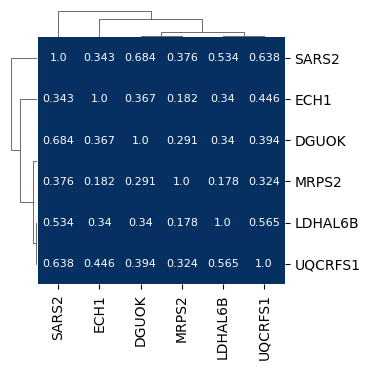

In [12]:
# Plot the heatmap

n_row = orf_df.shape[0]
n_col = orf_df.shape[1]
fig_width = n_row * 0.5 + 1
fig_height = n_col * 0.5 + 1

g = sns.clustermap(
    orf_df,
    cmap="RdBu",
    vmin=0,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    figsize=(fig_width, fig_height),
    cbar_pos=None,
)

clustermap_df = g.data2d

for i in range(len(clustermap_df)):
    for j in range(len(clustermap_df.columns)):
        gene_1 = clustermap_df.index[i]
        gene_2 = clustermap_df.columns[j]
        kg_gene_pair = orf_kg_df.loc[gene_1, gene_2]
        text = f"{kg_gene_pair}"
        x = j + 0.5  # Center the text horizontally
        y = i + 0.5  # Center the text vertically

        text_color = (
            "white"
            if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
            else "black"
        )

        g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color, fontdict={"size": 8})

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.savefig(f"figures/ORF-connections-{'-'.join(top_similar_orf)}.png", dpi=300)
plt.savefig(f"figures/ORF-connections-{'-'.join(top_similar_orf)}.svg", dpi=300)

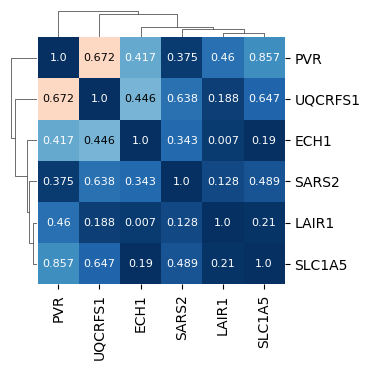

In [13]:
# Plot the heatmap

n_row = orf_df.shape[0]
n_col = orf_df.shape[1]
fig_width = n_row * 0.5 + 1
fig_height = n_col * 0.5 + 1

g = sns.clustermap(
    crispr_df,
    cmap="RdBu",
    vmin=0,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    figsize=(fig_width, fig_height),
    cbar_pos=None,
)

clustermap_df = g.data2d

for i in range(len(clustermap_df)):
    for j in range(len(clustermap_df.columns)):
        gene_1 = clustermap_df.index[i]
        gene_2 = clustermap_df.columns[j]
        kg_gene_pair = crispr_kg_df.loc[gene_1, gene_2]
        text = f"{kg_gene_pair}"
        x = j + 0.5  # Center the text horizontally
        y = i + 0.5  # Center the text vertically

        text_color = (
            "white"
            if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
            else "black"
        )

        g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color, fontdict={"size": 8})

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.savefig(f"figures/CRISPR-connections-{'-'.join(top_similar_crispr)}.png", dpi=300)
plt.savefig(f"figures/CRISPR-connections-{'-'.join(top_similar_crispr)}.svg", dpi=300)